# How are the mean states of CESM1 and CESM2 different in the Arctic?

__Focus on the fall months (August - November) when OLR emergence differs and the melt season (April - September) when energy is taken up.__

Melt Season Variables:
- Sea Ice Fraction
- Absorbed Solar Radiation

Heat Season Variables:
- Surface Temperature
- Surface upwelling longwave radiation
- TOA clear-sky outgoing longwave radiation
- TOA all-sky outgoing longwave radiation

To plot:
- Surface OLR (no trends), 1920 - 2080
- Integrated melt season ASR, 1920 - 2080
- September sea ice fraction, 1920 - 2080
- $\tau_{atm}$, 1920 - 2080

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    np, xr, plt, sns, os, 
    datetime, gridspec, 
    Iterable, cmaps, glob, copy,
    dask,pd
    )

from functions import (
    add_weights,
    to_png, stats, fix_cesm_time
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Open Arctic timeseries from the different ensembles.

In [2]:
cesm2cmip5_tseries_savedir = '/glade/u/home/jonahshaw/w/LENS/CESM2-CMIP5/ArcticTimeSeries/'
cesm1le_tseries_savedir    = '/glade/u/home/jonahshaw/w/LENS/CESM1-LE/ArcticTimeSeries/'

In [3]:
ls $cesm1le_tseries_savedir

CESM1_ForcedResponse_ArcticTimeSeries.nc
CESM1_Members_HIST1920_2000_ArcticTimeSeries.nc
CESM1_PIControl_ArcticTimeSeries.nc
CESM1_RCP8.5Members_ArcticTimeSeries.nc
old/


In [4]:
cesm2cmip5_ensemblemembers_histfile = '%s/%s' % (cesm2cmip5_tseries_savedir,'CESM2_CMIP5_Members_HIST1920_2000_ArcticTimeSeries.nc')
cesm2cmip5_ensemblemembers_rcpfile  = '%s/%s' % (cesm2cmip5_tseries_savedir,'CESM2_CMIP5_RCP8.5Members_ArcticTimeSeries.nc')

cesm1le_ensemblemembers_histfile    = '%s/%s' % (cesm1le_tseries_savedir,'CESM1_Members_HIST1920_2000_ArcticTimeSeries.nc')
cesm1le_ensemblemembers_rcpfile     = '%s/%s' % (cesm1le_tseries_savedir,'CESM1_RCP8.5Members_ArcticTimeSeries.nc')

In [5]:
cesm2cmip5_fulltseries = xr.open_mfdataset([cesm2cmip5_ensemblemembers_histfile,cesm2cmip5_ensemblemembers_rcpfile])
cesm1le_fulltseries    = xr.open_mfdataset([cesm1le_ensemblemembers_histfile,cesm1le_ensemblemembers_rcpfile])

In [6]:
cesm2cmip5_picfile = '%s/%s' % (cesm2cmip5_tseries_savedir,'CESM2_CMIP5_PIControl_ArcticTimeSeries.nc')
cesm1le_picfile    = '%s/%s' % (cesm1le_tseries_savedir,'CESM1_PIControl_ArcticTimeSeries.nc')

In [7]:
cesm2cmip5_pic_ds = xr.open_dataset(cesm2cmip5_picfile)
cesm1le_pic_ds = xr.open_dataset(cesm1le_picfile)

Variable processing for historical + forced timeseries.

In [8]:
# Add surface upwelling radiation variable
cesm2cmip5_fulltseries['FLUS'] = cesm2cmip5_fulltseries['FLNS'] + cesm2cmip5_fulltseries['FLDS']
cesm1le_fulltseries['FLUS']    = cesm1le_fulltseries['FLNS'] + cesm1le_fulltseries['FLDS']

# Sum over the cloud optical depths
cesm2cmip5_fulltseries['CLDTAU'] = cesm2cmip5_fulltseries['TOT_CLD_VISTAU'].sum(dim='lev')
cesm1le_fulltseries['CLDTAU']    = cesm1le_fulltseries['TOT_CLD_VISTAU'].sum(dim='lev')

cesm2cmip5_fulltseries = cesm2cmip5_fulltseries.drop(['TOT_CLD_VISTAU','lev'])
cesm1le_fulltseries    = cesm1le_fulltseries.drop(['TOT_CLD_VISTAU','lev'])

Variable processing for pre-industrial timeseries.

In [9]:
# Add surface upwelling radiation variable
cesm2cmip5_pic_ds['FLUS'] = cesm2cmip5_pic_ds['FLNS'] + cesm2cmip5_pic_ds['FLDS']
cesm1le_pic_ds['FLUS']    = cesm1le_pic_ds['FLNS'] + cesm1le_pic_ds['FLDS']

# Sum over the cloud optical depths (I haven't processed this variable for the PIC simulations)
# cesm2cmip5_pic_ds['CLDTAU'] = cesm2cmip5_pic_ds['TOT_CLD_VISTAU'].sum(dim='lev')
# cesm1le_pic_ds['CLDTAU']    = cesm1le_pic_ds['TOT_CLD_VISTAU'].sum(dim='lev')

# cesm2cmip5_pic_ds = cesm2cmip5_pic_ds.drop(['TOT_CLD_VISTAU','lev'])
# cesm1le_pic_ds    = cesm1le_pic_ds.drop(['TOT_CLD_VISTAU','lev'])

#### Bootstrap CESM1-LE to 10 members w/ confidence intervals.

I need to re-organize so that it is indexed by year and month instead of time. This will allow me to bootstrap efficiently.

In [10]:
cesm1le_fulltseries    = cesm1le_fulltseries.assign_coords({'year':cesm1le_fulltseries['time.year'],
                                                            'month':cesm1le_fulltseries['time.month'],
                                                           }
                                                          )
cesm2cmip5_fulltseries = cesm2cmip5_fulltseries.assign_coords({'year':cesm2cmip5_fulltseries['time.year'],
                                                               'month':cesm2cmip5_fulltseries['time.month'],
                                                              }
                                                             )


cesm1le_pic_ds    = cesm1le_pic_ds.assign_coords({'year':cesm1le_pic_ds['time.year'],
                                                  'month':cesm1le_pic_ds['time.month'],
                                                 }
                                                )
cesm2cmip5_pic_ds = cesm2cmip5_pic_ds.assign_coords({'year':cesm2cmip5_pic_ds['time.year'],
                                                     'month':cesm2cmip5_pic_ds['time.month'],
                                                    }
                                                   )

In [11]:
cesm1le_tseries_reorg = cesm1le_fulltseries.to_dataframe().reset_index().set_index(['year','month','ens']).to_xarray().drop('time')
cesm2cmip5_tseries_reorg = cesm2cmip5_fulltseries.to_dataframe().reset_index().set_index(['year','month','ens']).to_xarray().drop('time')

cesm1le_pic_reorg = cesm1le_pic_ds.to_dataframe().reset_index().set_index(['year','month']).to_xarray().drop('time')
cesm2cmip5_pic_reorg = cesm2cmip5_pic_ds.to_dataframe().reset_index().set_index(['year','month']).to_xarray().drop('time')

del cesm1le_fulltseries,cesm2cmip5_fulltseries,cesm1le_pic_ds,cesm2cmip5_pic_ds

In [7]:
# cesm1le_fulltseries    = cesm1le_fulltseries.assign_coords({'year':cesm1le_fulltseries['time.year']})#.expand_dims('year0')
# cesm2cmip5_fulltseries = cesm2cmip5_fulltseries.assign_coords({'year':cesm2cmip5_fulltseries['time.year']})#.expand_dims('year0')

# cesm1le_fulltseries    = cesm1le_fulltseries.assign_coords({'month':cesm1le_fulltseries['time.month']})#.expand_dims('month')
# cesm2cmip5_fulltseries = cesm2cmip5_fulltseries.assign_coords({'month':cesm2cmip5_fulltseries['time.month']})#.expand_dims('month')

In [8]:
# cesm1le_tseries_reorg = cesm1le_fulltseries.to_dataframe().reset_index().set_index(['year','month','ens']).to_xarray().drop('time')
# cesm2cmip5_tseries_reorg = cesm2cmip5_fulltseries.to_dataframe().reset_index().set_index(['year','month','ens']).to_xarray().drop('time')

# del cesm1le_fulltseries,cesm2cmip5_fulltseries

#### Calculate the total shortwave radiative energy absorbed over the melt season (a la Sledd et als)

We therefore calculate the net SW energy absorbed over the melt season, March through September. These months account for 95% of incoming SW radiation in the Arctic (Cao et al. 2016). The accumulated SW, $SW_{acc}$, is found by calculating the net SW flux absorbed at each grid box multiplied by the area of its grid box, converting it to a measure of power. Further multiplying by the duration (in seconds) of each month yields an accumulated energy. This average net SW energy is then summed over the Arctic, again defined as the area north of the Arctic Circle, and summed over the melt season:

$$ SW_{acc} = \sum_{m=3}^{m=9} \sum_{i,j} (SW^{\downarrow} - SW^{\uparrow})_{i,j} \times A_{i,j} \times t_m $$

My timeseries are already spatially averaged, so I will ignore the area term. I just need to know the number of seconds per month.

In [13]:
days_per_month = [31,28,31,30,31,30,31,31,30,31,30,31]

seconds_per_month = np.array(days_per_month) * 24 * 60 * 60 # day/month * 24hours/day * 60min/hour * 60sec/min

In [14]:
seconds_per_month_da = xr.DataArray(data = seconds_per_month,
                                    dims = ['month'],
                                    coords = {'month':np.arange(1,13)},
                                    name = 'seconds per month'
                                   )


Accumulated shortwave calculation.

Historical and forced.

In [15]:
sw_acc_cesm1         = (cesm1le_tseries_reorg['FSNTOA']*seconds_per_month_da).sel(month=slice(3,9)).sum(dim='month')
sw_acc_surface_cesm1 = (cesm1le_tseries_reorg['FSNS']*seconds_per_month_da).sel(month=slice(3,9)).sum(dim='month')

sw_acc_cesm2         = (cesm2cmip5_tseries_reorg['FSNTOA']*seconds_per_month_da).sel(month=slice(3,9)).sum(dim='month')
sw_acc_surface_cesm2 = (cesm2cmip5_tseries_reorg['FSNS']*seconds_per_month_da).sel(month=slice(3,9)).sum(dim='month')

In [16]:
sw_acc_cesm1 = sw_acc_cesm1.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                          'description':'Top of Atmosphere shortwave energy Accumulated over the melt season (March-September) per unit area'
                                         })

sw_acc_surface_cesm1 = sw_acc_surface_cesm1.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                          'description':'Surface shortwave energy Accumulated over the melt season (March-September) per unit area'
                                                         })

sw_acc_cesm2 = sw_acc_cesm2.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                          'description':'Top of Atmosphere shortwave energy Accumulated over the melt season (March-September) per unit area'
                                         })

sw_acc_surface_cesm2 = sw_acc_surface_cesm2.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                          'description':'Surface shortwave energy Accumulated over the melt season (March-September) per unit area'
                                                         })

In [17]:
cesm1le_tseries_reorg['SW_ACC_TOA'] = sw_acc_cesm1
cesm1le_tseries_reorg['SW_ACC_SURFACE'] = sw_acc_surface_cesm1

cesm2cmip5_tseries_reorg['SW_ACC_TOA'] = sw_acc_cesm2
cesm2cmip5_tseries_reorg['SW_ACC_SURFACE'] = sw_acc_surface_cesm2

del sw_acc_cesm1,sw_acc_surface_cesm1
del sw_acc_cesm2,sw_acc_surface_cesm2

Pre-Industrial.

In [18]:
sw_acc_cesm1_pic         = (cesm1le_pic_reorg['FSNTOA']*seconds_per_month_da).sel(month=slice(3,9)).sum(dim='month')
sw_acc_surface_cesm1_pic = (cesm1le_pic_reorg['FSNS']*seconds_per_month_da).sel(month=slice(3,9)).sum(dim='month')

sw_acc_cesm2_pic         = (cesm2cmip5_pic_reorg['FSNTOA']*seconds_per_month_da).sel(month=slice(3,9)).sum(dim='month')
sw_acc_surface_cesm2_pic = (cesm2cmip5_pic_reorg['FSNS']*seconds_per_month_da).sel(month=slice(3,9)).sum(dim='month')

In [19]:
sw_acc_cesm1_pic = sw_acc_cesm1_pic.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                  'description':'Top of Atmosphere shortwave energy Accumulated over the melt season (March-September) per unit area'
                                                 })

sw_acc_surface_cesm1_pic = sw_acc_surface_cesm1_pic.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                                  'description':'Surface shortwave energy Accumulated over the melt season (March-September) per unit area'
                                                                 })

sw_acc_cesm2_pic = sw_acc_cesm2_pic.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                  'description':'Top of Atmosphere shortwave energy Accumulated over the melt season (March-September) per unit area'
                                                 })

sw_acc_surface_cesm2_pic = sw_acc_surface_cesm2_pic.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                                  'description':'Surface shortwave energy Accumulated over the melt season (March-September) per unit area'
                                                                 })

In [20]:
cesm1le_pic_reorg['SW_ACC_TOA'] = sw_acc_cesm1_pic
cesm1le_pic_reorg['SW_ACC_SURFACE'] = sw_acc_surface_cesm1_pic

cesm2cmip5_pic_reorg['SW_ACC_TOA'] = sw_acc_cesm2_pic
cesm2cmip5_pic_reorg['SW_ACC_SURFACE'] = sw_acc_surface_cesm2_pic

del sw_acc_cesm1_pic,sw_acc_surface_cesm1_pic
del sw_acc_cesm2_pic,sw_acc_surface_cesm2_pic

Heat season longwave calculation.

Historical and forced.

In [84]:
lw_emm_cesm1         = (cesm1le_tseries_reorg['FLUT']*seconds_per_month_da).sel(month=slice(8,11)).sum(dim='month')
lw_emm_surface_cesm1 = (cesm1le_tseries_reorg['FLUS']*seconds_per_month_da).sel(month=slice(8,11)).sum(dim='month')

lw_emm_cesm2         = (cesm2cmip5_tseries_reorg['FLUT']*seconds_per_month_da).sel(month=slice(8,11)).sum(dim='month')
lw_emm_surface_cesm2 = (cesm2cmip5_tseries_reorg['FLUS']*seconds_per_month_da).sel(month=slice(8,11)).sum(dim='month')

In [85]:
lw_emm_cesm1 = lw_emm_cesm1.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                          'description':'Top of Atmosphere longwave energy emitted over October-December per unit area'
                                         })

lw_emm_surface_cesm1 = lw_emm_surface_cesm1.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                          'description':'Surface longwave energy emitted over October-December per unit area'
                                                         })

lw_emm_cesm2 = lw_emm_cesm2.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                          'description':'Top of Atmosphere longwave energy emitted over October-December per unit area'
                                         })

lw_emm_surface_cesm2 = lw_emm_surface_cesm2.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                          'description':'Surface longwave energy emitted over October-December per unit area'
                                                         })

In [86]:
cesm1le_tseries_reorg['LW_EMM_TOA'] = lw_emm_cesm1
cesm1le_tseries_reorg['LW_EMM_SURFACE'] = lw_emm_surface_cesm1

cesm2cmip5_tseries_reorg['LW_EMM_TOA'] = lw_emm_cesm2
cesm2cmip5_tseries_reorg['LW_EMM_SURFACE'] = lw_emm_surface_cesm2

del lw_emm_cesm1,lw_emm_surface_cesm1
del lw_emm_cesm2,lw_emm_surface_cesm2

Pre-Industrial

In [87]:
lw_emm_cesm1_pic         = (cesm1le_pic_reorg['FLUT']*seconds_per_month_da).sel(month=slice(8,11)).sum(dim='month')
lw_emm_surface_cesm1_pic = (cesm1le_pic_reorg['FLUS']*seconds_per_month_da).sel(month=slice(8,11)).sum(dim='month')

lw_emm_cesm2_pic         = (cesm2cmip5_pic_reorg['FLUT']*seconds_per_month_da).sel(month=slice(8,11)).sum(dim='month')
lw_emm_surface_cesm2_pic = (cesm2cmip5_pic_reorg['FLUS']*seconds_per_month_da).sel(month=slice(8,11)).sum(dim='month')

In [88]:
lw_emm_cesm1_pic = lw_emm_cesm1_pic.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                  'description':'Top of Atmosphere longwave energy emitted over October-December per unit area'
                                                 })

lw_emm_surface_cesm1_pic = lw_emm_surface_cesm1_pic.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                                  'description':'Surface longwave energy emitted over October-December per unit area'
                                                                 })

lw_emm_cesm2_pic = lw_emm_cesm2_pic.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                  'description':'Top of Atmosphere longwave energy emitted over October-December per unit area'
                                                 })

lw_emm_surface_cesm2_pic = lw_emm_surface_cesm2_pic.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                                  'description':'Surface longwave energy emitted over October-December per unit area'
                                                                 })

In [89]:
cesm1le_pic_reorg['LW_EMM_TOA'] = lw_emm_cesm1_pic
cesm1le_pic_reorg['LW_EMM_SURFACE'] = lw_emm_surface_cesm1_pic

cesm2cmip5_pic_reorg['LW_EMM_TOA'] = lw_emm_cesm2_pic
cesm2cmip5_pic_reorg['LW_EMM_SURFACE'] = lw_emm_surface_cesm2_pic

del lw_emm_cesm1_pic,lw_emm_surface_cesm1_pic
del lw_emm_cesm2_pic,lw_emm_surface_cesm2_pic

#### Bootstrap CESM1-LE to 10 members w/ confidence intervals.

In [90]:
%%time 

cesm1_trends = {}

nbootstraps = 3000
gen = np.random.Generator(np.random.PCG64()) # generator object for sampling a n-D array
    
data_ds = cesm1le_tseries_reorg.transpose('ens','month','year')
    
N_ens = 10 # number of members is 10 always

# for _var in var_list:
#     print(_var)

#     data = data_ds[_var]
    
for _var in data_ds:
    
    # if _var in ['SW_ACC_TOA','SW_ACC_SURFACE']: 
    #     break
    
    print(_var)
    data = data_ds[_var]

    # Compute percentiles using bootstrapping
    # lower_percentile = []
    # upper_percentile = []
    mean_emergence = []

    alpha = 0.95
    alpha_offset = (1 - alpha) / 2

    lower_bound = 100*(alpha_offset)
    upper_bound = 100*(1-alpha_offset)

    # We are asking in the CESM2-CMIP5 mean is different from the CESM1-LE, so I am just resampling means
    for i in range(nbootstraps): # bootstrap, calculating percentiles
        # resample along the ensemble dimension (axis 0)
        resample_emergence = gen.choice(data, size=N_ens, replace=True,axis=0)
        # compute percentiles along the ensemble dimension (axis 0)
        mean_emergence.append(np.mean(resample_emergence,axis=0))

    _lower_mean_bstrap = np.percentile(mean_emergence,lower_bound,axis=0) # take the mean percentile along the correct axis
    _upper_mean_bstrap = np.percentile(mean_emergence,upper_bound,axis=0)
    _mean_mean_bstrap  = np.mean(mean_emergence,axis=0)

    if _var in ['SW_ACC_TOA','SW_ACC_SURFACE','LW_EMM_TOA','LW_EMM_SURFACE']: # handle variables without the month dimension
        _emergence_LP_da = xr.DataArray(
            data=np.array([_lower_mean_bstrap,_mean_mean_bstrap,_upper_mean_bstrap]),
            dims=["bound","year"],
            coords=dict(
                bound=[lower_bound,50,upper_bound], # bounds are percentiles now
                year=data_ds.year,
            ),
            name = _var
        )
        #     break
    else:
        _emergence_LP_da = xr.DataArray(
            data=np.array([_lower_mean_bstrap,_mean_mean_bstrap,_upper_mean_bstrap]),
            dims=["bound","month","year"],
            coords=dict(
                bound=[lower_bound,50,upper_bound], # bounds are percentiles now
                month=np.arange(1,13,1),
                year=data_ds.year,
            ),
            name = _var
        )
    
    cesm1_trends[_var] = _emergence_LP_da
    
cesm1le_vars_bstrap10_ds = xr.merge(cesm1_trends.values())

FLUT
FLUTC
FLNS
FLDS
FSNTOA
FSNTOAC
FSNS
FSNSC
TS
ICEFRAC
TMQ
FLUS
CLDTAU
SW_ACC_TOA
SW_ACC_SURFACE
LW_EMM_TOA
LW_EMM_SURFACE
CPU times: user 18.2 s, sys: 1.22 s, total: 19.4 s
Wall time: 19.9 s


### Do the plots!

To plot:
- Surface OLR (no trends), 1920 - 2080
- Integrated melt season ASR, 1920 - 2080
- September sea ice fraction, 1920 - 2080
- $\tau_{atm}$, 1920 - 2080

__Surface OLR (no trends), 1920 - 2080__

I expect that CESM1 will be lower than CESM2. There is a known cold bias in CESM1.

We've also seen that the CESM2 OLR trends are less than CESM1, so I expect to be able to see that here as well.

I expect that OLR increases in October and November will occur earlier in CESM2 than CESM1 since the mean sea ice state is less and the heat season will get push later in the year earlier in time. (_this does not appear_)

In [28]:
def is_ason(month):
    return (month >= 8) & (month <= 11)

__Surface Temperature__

Text(0.5, 0.98, 'Surface Temperature (1920-2080)')

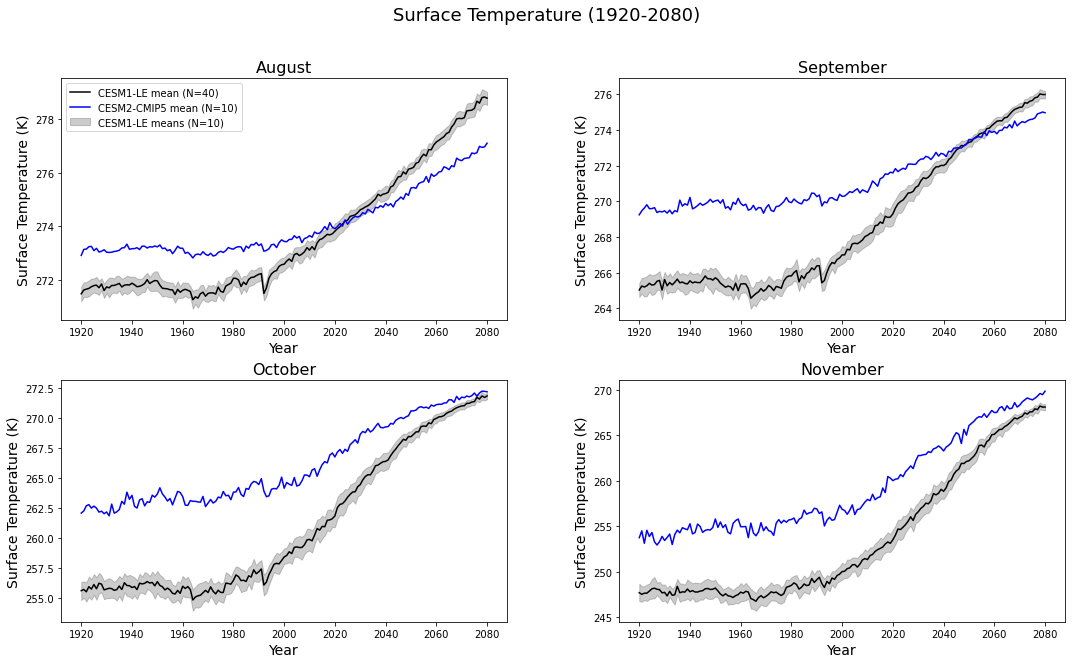

In [30]:
fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(18,10))
axs = axs.flat

fig.subplots_adjust(wspace=0.25,hspace=0.25)

months = ['August','September','October','November']

var = 'TS'

for _ax,(_,_month_cesm1),(_,_month_cesm2),_month_name,(_,_month_cesm1_CI) in zip(axs,
                                                                             cesm1le_tseries_reorg[var].sel(month=slice(8,11)).groupby('month'),
                                                                             cesm2cmip5_tseries_reorg[var].sel(month=slice(8,11)).groupby('month'),
                                                                             months,
                                                                             cesm1le_vars_bstrap10_ds[var].sel(month=slice(8,11)).groupby('month'),
                                                                            ):
    
    _ax.plot(_month_cesm1['year'],_month_cesm1.mean(dim='ens'),
            color='black',
            label='CESM1-LE mean (N=40)',
            )
    
    _ax.plot(_month_cesm2['year'],_month_cesm2.mean(dim='ens'),
            color='blue',
            label='CESM2-CMIP5 mean (N=10)',
            )
    
    _ax.fill_between(x=_month_cesm1_CI.year,
                     y1=_month_cesm1_CI.sel(bound=2.5,method='nearest'),
                     y2=_month_cesm1_CI.sel(bound=97.5,method='nearest'),
                     color='black',
                     alpha=0.2,
                     label='CESM1-LE means (N=10)',
                    )
    
    # _ax.set_ylim(0,0.3)
    # _ax.set_xlim(10,50)
    _ax.set_ylabel('Surface Temperature (K)',fontsize=14)
    _ax.set_xlabel('Year',fontsize=14)
    _ax.set_title(_month_name,fontsize=16)
    
axs[0].legend()
fig.suptitle('Surface Temperature (1920-2080)',fontsize=18)

__Surface Upwelling Longwave Radiation__

Text(0.5, 0.98, 'Surface Outgoing Longwave Radiation (1920-2080)')

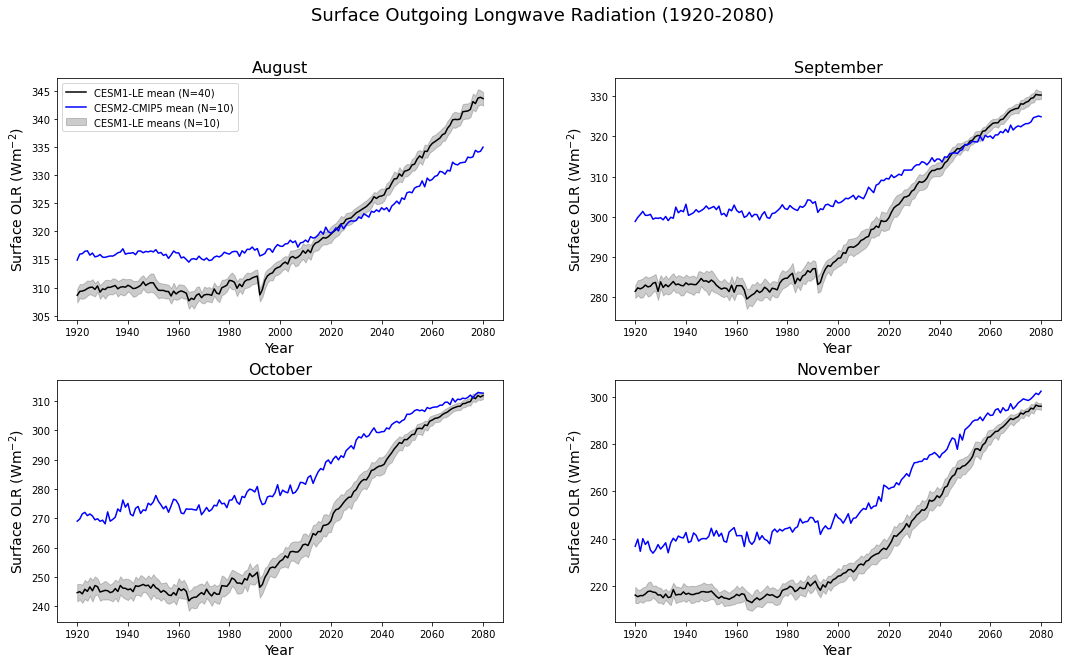

In [31]:
fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(18,10))
axs = axs.flat

fig.subplots_adjust(wspace=0.25,hspace=0.25)

months = ['August','September','October','November']

var = 'FLUS'

for _ax,(_,_month_cesm1),(_,_month_cesm2),_month_name,(_,_month_cesm1_CI) in zip(axs,
                                                                             cesm1le_tseries_reorg[var].sel(month=slice(8,11)).groupby('month'),
                                                                             cesm2cmip5_tseries_reorg[var].sel(month=slice(8,11)).groupby('month'),
                                                                             months,
                                                                             cesm1le_vars_bstrap10_ds[var].sel(month=slice(8,11)).groupby('month'),
                                                                            ):
    
    _ax.plot(_month_cesm1['year'],_month_cesm1.mean(dim='ens'),
            color='black',
            label='CESM1-LE mean (N=40)',
            )
    
    _ax.plot(_month_cesm2['year'],_month_cesm2.mean(dim='ens'),
            color='blue',
            label='CESM2-CMIP5 mean (N=10)',
            )
    
    _ax.fill_between(x=_month_cesm1_CI.year,
                     y1=_month_cesm1_CI.sel(bound=2.5,method='nearest'),
                     y2=_month_cesm1_CI.sel(bound=97.5,method='nearest'),
                     color='black',
                     alpha=0.2,
                     label='CESM1-LE means (N=10)',
                    )
    
    # _ax.set_ylim(0,0.3)
    # _ax.set_xlim(10,50)
    _ax.set_ylabel('Surface OLR (Wm$^{-2}$)',fontsize=14)
    _ax.set_xlabel('Year',fontsize=14)
    _ax.set_title(_month_name,fontsize=16)
    
axs[0].legend()
fig.suptitle('Surface Outgoing Longwave Radiation (1920-2080)',fontsize=18)

Text(0.5, 0.98, 'Arctic Sea Ice Fraction (1920-2080)')

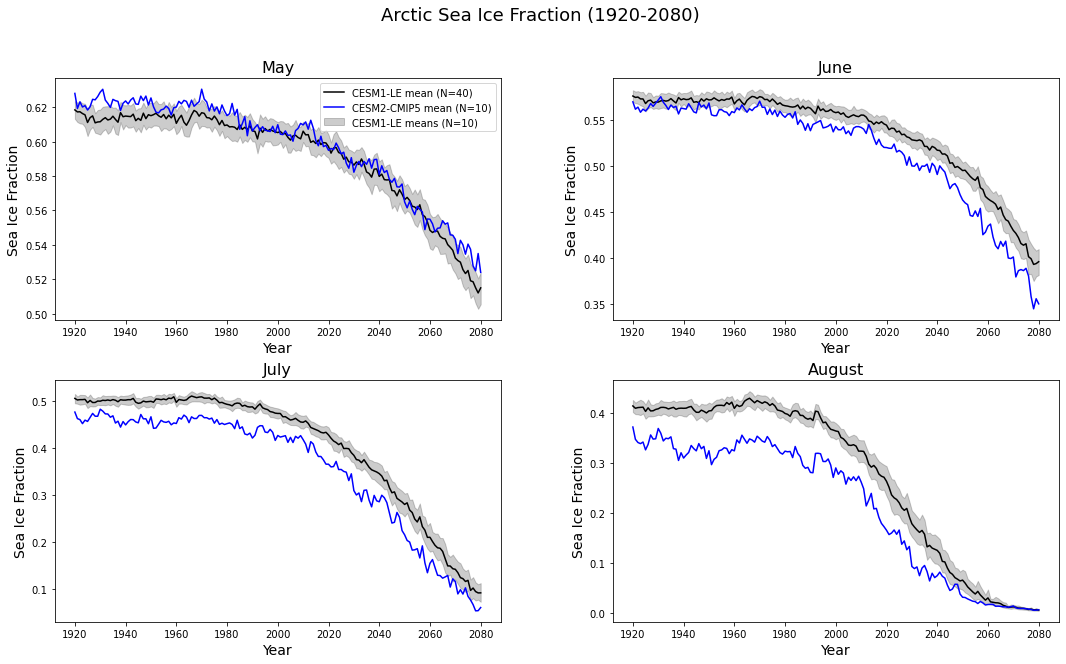

In [32]:
fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(18,10))
axs = axs.flat

fig.subplots_adjust(wspace=0.25,hspace=0.25)

months = ['May','June','July','August']

var = 'ICEFRAC'

for _ax,(_,_month_cesm1),(_,_month_cesm2),_month_name,(_,_month_cesm1_CI) in zip(axs,
                                                                             cesm1le_tseries_reorg[var].sel(month=slice(5,8)).groupby('month'),
                                                                             cesm2cmip5_tseries_reorg[var].sel(month=slice(5,8)).groupby('month'),
                                                                             months,
                                                                             cesm1le_vars_bstrap10_ds[var].sel(month=slice(5,8)).groupby('month'),
                                                                            ):
    
    _ax.plot(_month_cesm1['year'],_month_cesm1.mean(dim='ens'),
            color='black',
            label='CESM1-LE mean (N=40)',
            )
    
    _ax.plot(_month_cesm2['year'],_month_cesm2.mean(dim='ens'),
            color='blue',
            label='CESM2-CMIP5 mean (N=10)',
            )
    
    _ax.fill_between(x=_month_cesm1_CI.year,
                     y1=_month_cesm1_CI.sel(bound=2.5,method='nearest'),
                     y2=_month_cesm1_CI.sel(bound=97.5,method='nearest'),
                     color='black',
                     alpha=0.2,
                     label='CESM1-LE means (N=10)',
                    )
    
    # _ax.set_ylim(0,0.3)
    # _ax.set_xlim(10,50)
    _ax.set_ylabel('Sea Ice Fraction',fontsize=14)
    _ax.set_xlabel('Year',fontsize=14)
    _ax.set_title(_month_name,fontsize=16)
    
axs[0].legend()
fig.suptitle('Arctic Sea Ice Fraction (1920-2080)',fontsize=18)

Text(0.5, 0.98, 'Arctic Absorbed Shortwave Radiation (1920-2080)')

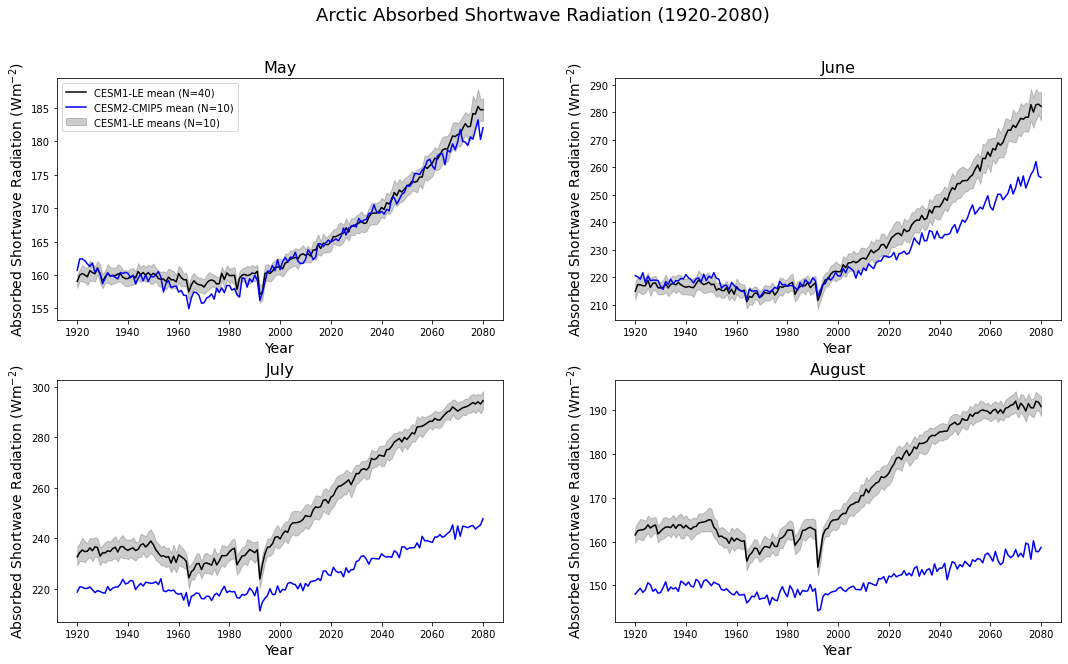

In [33]:
fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(18,10))
axs = axs.flat

fig.subplots_adjust(wspace=0.25,hspace=0.25)

months = ['May','June','July','August']

var = 'FSNTOA'

for _ax,(_,_month_cesm1),(_,_month_cesm2),_month_name,(_,_month_cesm1_CI) in zip(axs,
                                                                             cesm1le_tseries_reorg[var].sel(month=slice(5,8)).groupby('month'),
                                                                             cesm2cmip5_tseries_reorg[var].sel(month=slice(5,8)).groupby('month'),
                                                                             months,
                                                                             cesm1le_vars_bstrap10_ds[var].sel(month=slice(5,8)).groupby('month'),
                                                                            ):
    
    _ax.plot(_month_cesm1['year'],_month_cesm1.mean(dim='ens'),
            color='black',
            label='CESM1-LE mean (N=40)',
            )
    
    _ax.plot(_month_cesm2['year'],_month_cesm2.mean(dim='ens'),
            color='blue',
            label='CESM2-CMIP5 mean (N=10)',
            )
    
    _ax.fill_between(x=_month_cesm1_CI.year,
                     y1=_month_cesm1_CI.sel(bound=2.5,method='nearest'),
                     y2=_month_cesm1_CI.sel(bound=97.5,method='nearest'),
                     color='black',
                     alpha=0.2,
                     label='CESM1-LE means (N=10)',
                    )
    
    # _ax.set_ylim(0,0.3)
    # _ax.set_xlim(10,50)
    _ax.set_ylabel('Absorbed Shortwave Radiation (Wm$^{-2}$)',fontsize=14)
    _ax.set_xlabel('Year',fontsize=14)
    _ax.set_title(_month_name,fontsize=16)
    
axs[0].legend()
fig.suptitle('Arctic Absorbed Shortwave Radiation (1920-2080)',fontsize=18)

#### Surface ASR?

Text(0.5, 0.98, 'Arctic Absorbed Shortwave Radiation (surface) (1920-2080)')

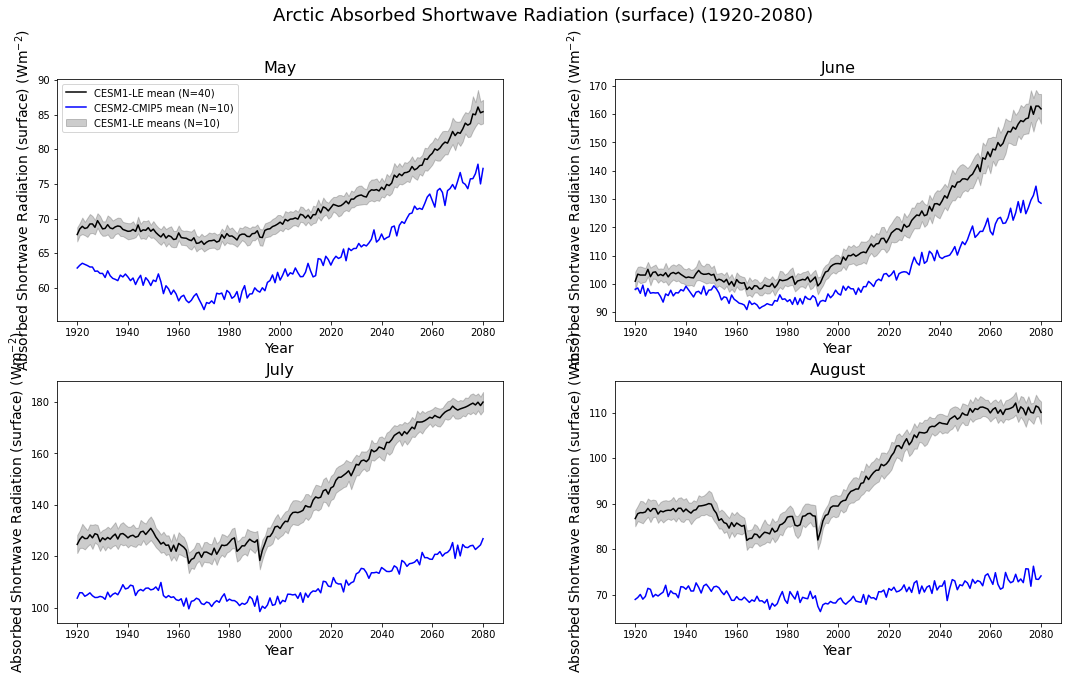

In [34]:
fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(18,10))
axs = axs.flat

fig.subplots_adjust(wspace=0.25,hspace=0.25)

months = ['May','June','July','August']

var = 'FSNS'

for _ax,(_,_month_cesm1),(_,_month_cesm2),_month_name,(_,_month_cesm1_CI) in zip(axs,
                                                                             cesm1le_tseries_reorg[var].sel(month=slice(5,8)).groupby('month'),
                                                                             cesm2cmip5_tseries_reorg[var].sel(month=slice(5,8)).groupby('month'),
                                                                             months,
                                                                             cesm1le_vars_bstrap10_ds[var].sel(month=slice(5,8)).groupby('month'),
                                                                            ):
    
    _ax.plot(_month_cesm1['year'],_month_cesm1.mean(dim='ens'),
            color='black',
            label='CESM1-LE mean (N=40)',
            )
    
    _ax.plot(_month_cesm2['year'],_month_cesm2.mean(dim='ens'),
            color='blue',
            label='CESM2-CMIP5 mean (N=10)',
            )
    
    _ax.fill_between(x=_month_cesm1_CI.year,
                     y1=_month_cesm1_CI.sel(bound=2.5,method='nearest'),
                     y2=_month_cesm1_CI.sel(bound=97.5,method='nearest'),
                     color='black',
                     alpha=0.2,
                     label='CESM1-LE means (N=10)',
                    )
    
    # _ax.set_ylim(0,0.3)
    # _ax.set_xlim(10,50)
    _ax.set_ylabel('Absorbed Shortwave Radiation (surface) (Wm$^{-2}$)',fontsize=14)
    _ax.set_xlabel('Year',fontsize=14)
    _ax.set_title(_month_name,fontsize=16)
    
axs[0].legend()
fig.suptitle('Arctic Absorbed Shortwave Radiation (surface) (1920-2080)',fontsize=18)

Cloud Tau (summed over all vertical levels)

Text(0.5, 0.98, 'Arctic Cloud Optical Thickness (1920-2080)')

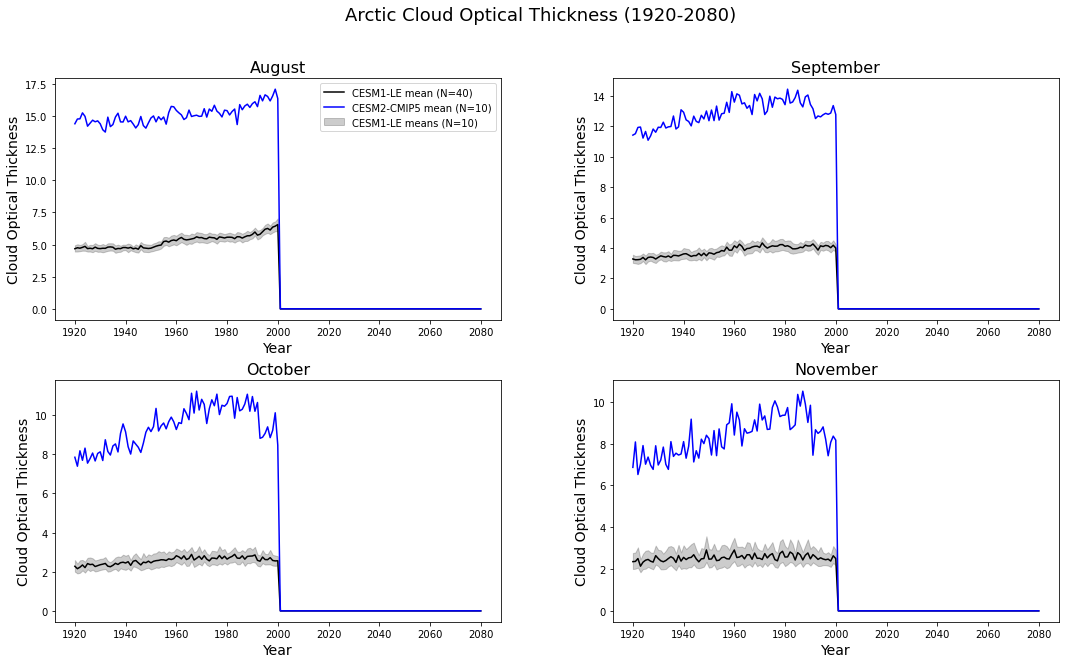

In [35]:
fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(18,10))
axs = axs.flat

fig.subplots_adjust(wspace=0.25,hspace=0.25)

months = ['August','September','October','November']

var = 'CLDTAU'

for _ax,(_,_month_cesm1),(_,_month_cesm2),_month_name,(_,_month_cesm1_CI) in zip(axs,
                                                                             cesm1le_tseries_reorg[var].sel(month=slice(8,11)).groupby('month'),
                                                                             cesm2cmip5_tseries_reorg[var].sel(month=slice(8,11)).groupby('month'),
                                                                             months,
                                                                             cesm1le_vars_bstrap10_ds[var].sel(month=slice(8,11)).groupby('month'),
                                                                            ):
    
    _ax.plot(_month_cesm1['year'],_month_cesm1.mean(dim='ens'),
            color='black',
            label='CESM1-LE mean (N=40)',
            )
    
    _ax.plot(_month_cesm2['year'],_month_cesm2.mean(dim='ens'),
            color='blue',
            label='CESM2-CMIP5 mean (N=10)',
            )
    
    _ax.fill_between(x=_month_cesm1_CI.year,
                     y1=_month_cesm1_CI.sel(bound=2.5,method='nearest'),
                     y2=_month_cesm1_CI.sel(bound=97.5,method='nearest'),
                     color='black',
                     alpha=0.2,
                     label='CESM1-LE means (N=10)',
                    )
    
    # _ax.set_ylim(0,0.3)
    # _ax.set_xlim(10,50)
    _ax.set_ylabel('Cloud Optical Thickness',fontsize=14)
    _ax.set_xlabel('Year',fontsize=14)
    _ax.set_title(_month_name,fontsize=16)
    
axs[0].legend()
fig.suptitle('Arctic Cloud Optical Thickness (1920-2080)',fontsize=18)

#### Plot accumulated shortwave

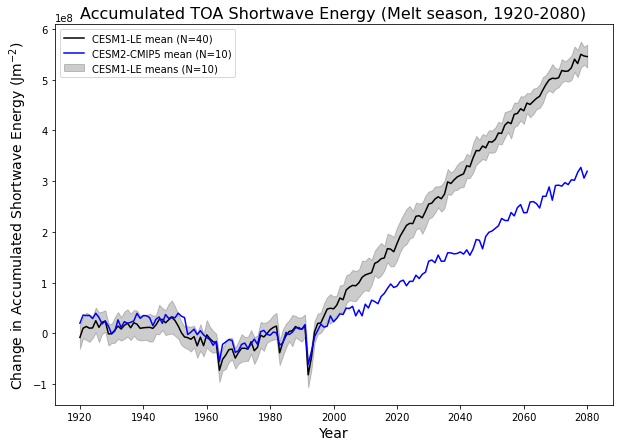

In [41]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,7))

var = 'SW_ACC_TOA'

_month_cesm1    = cesm1le_tseries_reorg[var]    - cesm1le_pic_reorg[var].mean(dim='year')
_month_cesm2    = cesm2cmip5_tseries_reorg[var] - cesm2cmip5_pic_reorg[var].mean(dim='year')
_month_cesm1_CI = cesm1le_vars_bstrap10_ds[var] - cesm1le_pic_reorg[var].mean(dim='year')

ax.plot(_month_cesm1['year'],_month_cesm1.mean(dim='ens'),
        color='black',
        label='CESM1-LE mean (N=40)',
        )

ax.plot(_month_cesm2['year'],_month_cesm2.mean(dim='ens'),
        color='blue',
        label='CESM2-CMIP5 mean (N=10)',
        )

ax.fill_between(x=_month_cesm1_CI.year,
                 y1=_month_cesm1_CI.sel(bound=2.5,method='nearest'),
                 y2=_month_cesm1_CI.sel(bound=97.5,method='nearest'),
                 color='black',
                 alpha=0.2,
                 label='CESM1-LE means (N=10)',
                )

# _ax.set_ylim(0,0.3)
ax.set_ylabel('Change in Accumulated Shortwave Energy (Jm$^{-2}$)',fontsize=14)
ax.set_xlabel('Year',fontsize=14)
ax.set_title('Accumulated TOA Shortwave Energy (Melt season, 1920-2080)',fontsize=16)
    
ax.legend()
# fig.suptitle('Accumulated Shortwave Energy (March - September) (1920-2080)',fontsize=18)

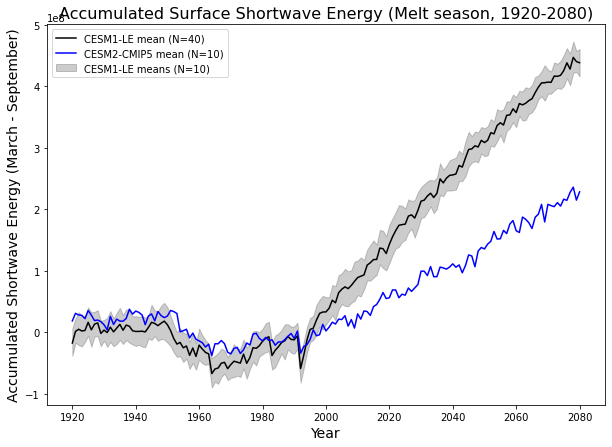

In [42]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,7))

var = 'SW_ACC_SURFACE'

_month_cesm1    = cesm1le_tseries_reorg[var]    - cesm1le_pic_reorg[var].mean(dim='year')
_month_cesm2    = cesm2cmip5_tseries_reorg[var] - cesm2cmip5_pic_reorg[var].mean(dim='year')
_month_cesm1_CI = cesm1le_vars_bstrap10_ds[var] - cesm1le_pic_reorg[var].mean(dim='year')

ax.plot(_month_cesm1['year'],_month_cesm1.mean(dim='ens'),
        color='black',
        label='CESM1-LE mean (N=40)',
        )

ax.plot(_month_cesm2['year'],_month_cesm2.mean(dim='ens'),
        color='blue',
        label='CESM2-CMIP5 mean (N=10)',
        )

ax.fill_between(x=_month_cesm1_CI.year,
                 y1=_month_cesm1_CI.sel(bound=2.5,method='nearest'),
                 y2=_month_cesm1_CI.sel(bound=97.5,method='nearest'),
                 color='black',
                 alpha=0.2,
                 label='CESM1-LE means (N=10)',
                )

# _ax.set_ylim(0,0.3)
ax.set_ylabel('Accumulated Shortwave Energy (March - September)',fontsize=14)
ax.set_xlabel('Year',fontsize=14)
ax.set_title('Accumulated Surface Shortwave Energy (Melt season, 1920-2080)',fontsize=16)
    
ax.legend()
# fig.suptitle('Accumulated Surface Shortwave Energy (Melt season, 1920-2080)',fontsize=18)

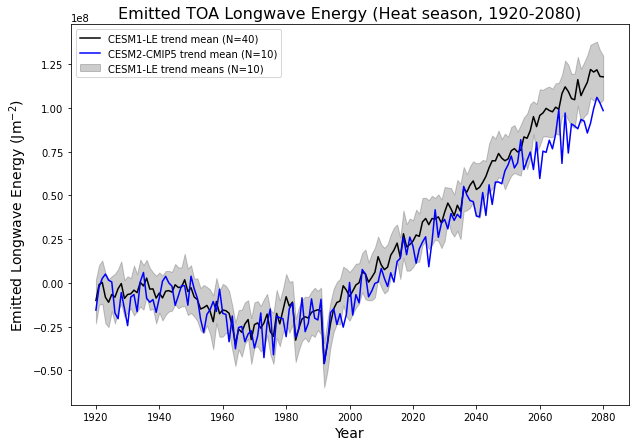

In [43]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,7))

var = 'LW_EMM_TOA'

_month_cesm1    = cesm1le_tseries_reorg[var]    - cesm1le_pic_reorg[var].mean(dim='year')
_month_cesm2    = cesm2cmip5_tseries_reorg[var] - cesm2cmip5_pic_reorg[var].mean(dim='year')
_month_cesm1_CI = cesm1le_vars_bstrap10_ds[var] - cesm1le_pic_reorg[var].mean(dim='year')

ax.plot(_month_cesm1['year'],_month_cesm1.mean(dim='ens'),
        color='black',
        label='CESM1-LE trend mean (N=40)',
        )

ax.plot(_month_cesm2['year'],_month_cesm2.mean(dim='ens'),
        color='blue',
        label='CESM2-CMIP5 trend mean (N=10)',
        )

ax.fill_between(x=_month_cesm1_CI.year,
                 y1=_month_cesm1_CI.sel(bound=2.5,method='nearest'),
                 y2=_month_cesm1_CI.sel(bound=97.5,method='nearest'),
                 color='black',
                 alpha=0.2,
                 label='CESM1-LE trend means (N=10)',
                )

# _ax.set_ylim(0,0.3)
ax.set_ylabel('Emitted Longwave Energy (Jm$^{-2}$)',fontsize=14)
ax.set_xlabel('Year',fontsize=14)
ax.set_title('Emitted TOA Longwave Energy (Heat season, 1920-2080)',fontsize=16)
    
ax.legend()
# fig.suptitle('Emitted TOA Longwave Energy (Heat season, 1920-2080)',fontsize=18)

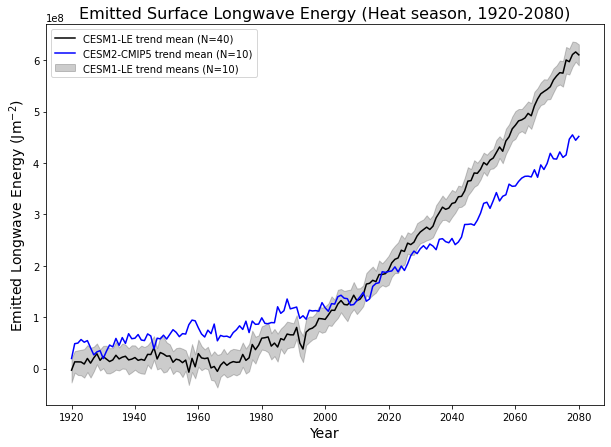

In [44]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,7))

var = 'LW_EMM_SURFACE'

_month_cesm1    = cesm1le_tseries_reorg[var]    - cesm1le_pic_reorg[var].mean(dim='year')
_month_cesm2    = cesm2cmip5_tseries_reorg[var] - cesm2cmip5_pic_reorg[var].mean(dim='year')
_month_cesm1_CI = cesm1le_vars_bstrap10_ds[var] - cesm1le_pic_reorg[var].mean(dim='year')

ax.plot(_month_cesm1['year'],_month_cesm1.mean(dim='ens'),
        color='black',
        label='CESM1-LE trend mean (N=40)',
        )

ax.plot(_month_cesm2['year'],_month_cesm2.mean(dim='ens'),
        color='blue',
        label='CESM2-CMIP5 trend mean (N=10)',
        )

ax.fill_between(x=_month_cesm1_CI.year,
                 y1=_month_cesm1_CI.sel(bound=2.5,method='nearest'),
                 y2=_month_cesm1_CI.sel(bound=97.5,method='nearest'),
                 color='black',
                 alpha=0.2,
                 label='CESM1-LE trend means (N=10)',
                )

# _ax.set_ylim(0,0.3)
ax.set_ylabel('Emitted Longwave Energy (Jm$^{-2}$)',fontsize=14)
ax.set_xlabel('Year',fontsize=14)
ax.set_title('Emitted Surface Longwave Energy (Heat season, 1920-2080)',fontsize=16)
    
ax.legend()
# fig.suptitle('Emitted Longwave Energy at the Surface (October-December, 1920-2080)',fontsize=18)

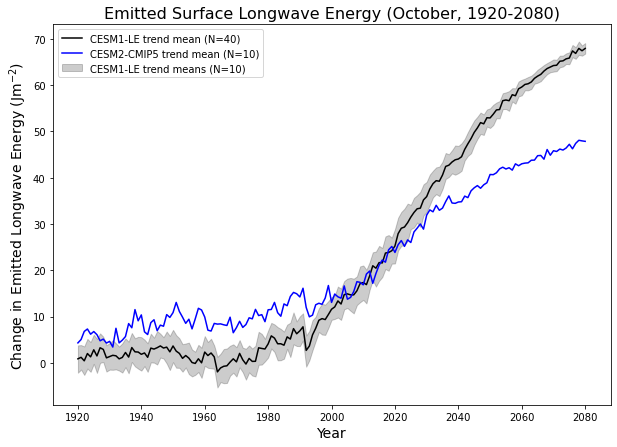

In [55]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,7))

var = 'FLUS'
month = 10

_month_cesm1    = (cesm1le_tseries_reorg[var]    - cesm1le_pic_reorg[var].mean(dim='year')).sel(month=month)
_month_cesm2    = (cesm2cmip5_tseries_reorg[var] - cesm2cmip5_pic_reorg[var].mean(dim='year')).sel(month=month)
_month_cesm1_CI = (cesm1le_vars_bstrap10_ds[var] - cesm1le_pic_reorg[var].mean(dim='year')).sel(month=month)

ax.plot(_month_cesm1['year'],_month_cesm1.mean(dim='ens'),
        color='black',
        label='CESM1-LE trend mean (N=40)',
        )

ax.plot(_month_cesm2['year'],_month_cesm2.mean(dim='ens'),
        color='blue',
        label='CESM2-CMIP5 trend mean (N=10)',
        )

ax.fill_between(x=_month_cesm1_CI.year,
                 y1=_month_cesm1_CI.sel(bound=2.5,method='nearest'),
                 y2=_month_cesm1_CI.sel(bound=97.5,method='nearest'),
                 color='black',
                 alpha=0.2,
                 label='CESM1-LE trend means (N=10)',
                )

# _ax.set_ylim(0,0.3)
ax.set_ylabel('Change in Emitted Longwave Energy (Jm$^{-2}$)',fontsize=14)
ax.set_xlabel('Year',fontsize=14)
ax.set_title('Emitted Surface Longwave Energy (October, 1920-2080)',fontsize=16)
    
ax.legend()
# fig.suptitle('Emitted Longwave Energy at the Surface (October-December, 1920-2080)',fontsize=18)

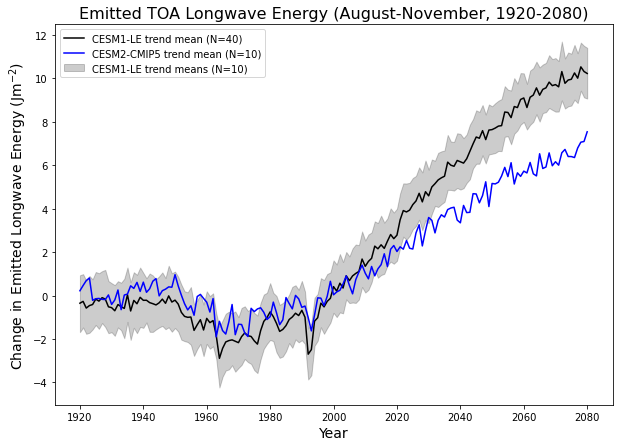

In [61]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,7))

var = 'FLUT'
# month = 10

_month_cesm1    = (cesm1le_tseries_reorg[var]    - cesm1le_pic_reorg[var].mean(dim='year')).sel(month=slice(8,11)).mean(dim='month')
_month_cesm2    = (cesm2cmip5_tseries_reorg[var] - cesm2cmip5_pic_reorg[var].mean(dim='year')).sel(month=slice(8,11)).mean(dim='month')
_month_cesm1_CI = (cesm1le_vars_bstrap10_ds[var] - cesm1le_pic_reorg[var].mean(dim='year')).sel(month=slice(8,11)).mean(dim='month')

ax.plot(_month_cesm1['year'],_month_cesm1.mean(dim='ens'),
        color='black',
        label='CESM1-LE trend mean (N=40)',
        )

ax.plot(_month_cesm2['year'],_month_cesm2.mean(dim='ens'),
        color='blue',
        label='CESM2-CMIP5 trend mean (N=10)',
        )

ax.fill_between(x=_month_cesm1_CI.year,
                 y1=_month_cesm1_CI.sel(bound=2.5,method='nearest'),
                 y2=_month_cesm1_CI.sel(bound=97.5,method='nearest'),
                 color='black',
                 alpha=0.2,
                 label='CESM1-LE trend means (N=10)',
                )

# _ax.set_ylim(0,0.3)
ax.set_ylabel('Change in Emitted Longwave Energy (Jm$^{-2}$)',fontsize=14)
ax.set_xlabel('Year',fontsize=14)
ax.set_title('Emitted TOA Longwave Energy (August-November, 1920-2080)',fontsize=16)
    
ax.legend()
# fig.suptitle('Emitted Longwave Energy at the Surface (October-December, 1920-2080)',fontsize=18)

#### Explain CESM1 vs. CESM2 differences

Text(1924, 114000000.0, 'b')

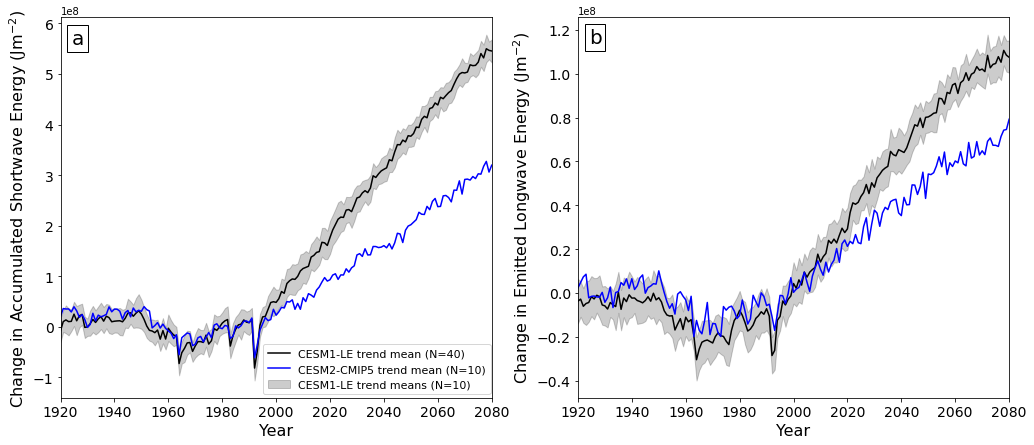

In [126]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(17,7))

var = 'SW_ACC_TOA'
var2 = 'LW_EMM_TOA'
# var2 = 'FLUT'
# month = 10

_month_cesm1    = (cesm1le_tseries_reorg[var]    - cesm1le_pic_reorg[var].mean(dim='year'))#.sel(month=slice(8,11)).mean(dim='month')
_month_cesm2    = (cesm2cmip5_tseries_reorg[var] - cesm2cmip5_pic_reorg[var].mean(dim='year'))#.sel(month=slice(8,11)).mean(dim='month')
_month_cesm1_CI = (cesm1le_vars_bstrap10_ds[var] - cesm1le_pic_reorg[var].mean(dim='year'))#.sel(month=slice(8,11)).mean(dim='month')

_month_cesm1_var2    = (cesm1le_tseries_reorg[var2]    - cesm1le_pic_reorg[var2].mean(dim='year'))
_month_cesm2_var2    = (cesm2cmip5_tseries_reorg[var2] - cesm2cmip5_pic_reorg[var2].mean(dim='year'))
_month_cesm1_CI_var2 = (cesm1le_vars_bstrap10_ds[var2] - cesm1le_pic_reorg[var2].mean(dim='year'))

# _month_cesm1_var2    = (cesm1le_tseries_reorg[var2]    - cesm1le_pic_reorg[var2].mean(dim='year')).sel(month=slice(8,11)).mean(dim='month')
# _month_cesm2_var2    = (cesm2cmip5_tseries_reorg[var2] - cesm2cmip5_pic_reorg[var2].mean(dim='year')).sel(month=slice(8,11)).mean(dim='month')
# _month_cesm1_CI_var2 = (cesm1le_vars_bstrap10_ds[var2] - cesm1le_pic_reorg[var2].mean(dim='year')).sel(month=slice(8,11)).mean(dim='month')

# Plot melt season accumulated shortwave energy in the first panel
axs[0].plot(_month_cesm1['year'],_month_cesm1.mean(dim='ens'),
        color='black',
        label='CESM1-LE trend mean (N=40)',
        )

axs[0].plot(_month_cesm2['year'],_month_cesm2.mean(dim='ens'),
        color='blue',
        label='CESM2-CMIP5 trend mean (N=10)',
        )

axs[0].fill_between(x=_month_cesm1_CI.year,
                 y1=_month_cesm1_CI.sel(bound=2.5,method='nearest'),
                 y2=_month_cesm1_CI.sel(bound=97.5,method='nearest'),
                 color='black',
                 alpha=0.2,
                 label='CESM1-LE trend means (N=10)',
                )

# Plot August-November emitted longwave energy in the second panel
axs[1].plot(_month_cesm1_var2['year'],_month_cesm1_var2.mean(dim='ens'),
        color='black',
        label='CESM1-LE trend mean (N=40)',
        )

axs[1].plot(_month_cesm2_var2['year'],_month_cesm2_var2.mean(dim='ens'),
        color='blue',
        label='CESM2-CMIP5 trend mean (N=10)',
        )

axs[1].fill_between(x=_month_cesm1_CI_var2.year,
                 y1=_month_cesm1_CI_var2.sel(bound=2.5,method='nearest'),
                 y2=_month_cesm1_CI_var2.sel(bound=97.5,method='nearest'),
                 color='black',
                 alpha=0.2,
                 label='CESM1-LE trend means (N=10)',
                )


# label panel 1
axs[0].set_ylabel('Change in Accumulated Shortwave Energy (Jm$^{-2}$)',fontsize=16)
axs[0].set_xlabel('Year',fontsize=16)
axs[0].tick_params(labelsize=14)
axs[0].set_xlim(1920,2080)


# label panel 2
axs[1].set_ylabel('Change in Emitted Longwave Energy (Jm$^{-2}$)',fontsize=16)
axs[1].set_xlabel('Year',fontsize=16)
axs[1].tick_params(labelsize=14)
axs[1].set_xlim(1920,2080)

# axs[0].set_title('Accumulated TOA Shortwave Energy (August-November, 1920-2080)',fontsize=16)
    
axs[0].legend(loc=(0.47,0.01),fontsize=11)

props = dict(facecolor='white', alpha=1)

axs[0].text(1924,5.6e8,'a',fontsize=20,bbox=props)
axs[1].text(1924,1.14e8,'b',fontsize=20,bbox=props)

# fig.suptitle('Emitted Longwave Energy at the Surface (October-December, 1920-2080)',fontsize=18)